In [1]:
!pip install segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00


In [2]:
from torch.amp import autocast, GradScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
from glob import glob
from PIL import Image

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
class ISIC2017Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        ISIC 2017 Dataset for segmentation (Task 1)

        Args:
            root_dir: Path to ISIC 2017 dataset directory
            split: 'train', 'val', or 'test'
            transform: albumentations transform
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # ISIC 2017 folders are double-nested on Kaggle!
        if split == 'train':
            img_dir = os.path.join(root_dir, 'ISIC-2017_Training_Data', 'ISIC-2017_Training_Data')
            mask_dir = os.path.join(root_dir, 'ISIC-2017_Training_Part1_GroundTruth', 'ISIC-2017_Training_Part1_GroundTruth')
        elif split == 'val':
            img_dir = os.path.join(root_dir, 'ISIC-2017_Validation_Data', 'ISIC-2017_Validation_Data')
            mask_dir = os.path.join(root_dir, 'ISIC-2017_Validation_Part1_GroundTruth', 'ISIC-2017_Validation_Part1_GroundTruth')
        elif split == 'test':
            img_dir = os.path.join(root_dir, 'ISIC-2017_Test_v2_Data', 'ISIC-2017_Test_v2_Data')
            mask_dir = os.path.join(root_dir, 'ISIC-2017_Test_v2_Part1_GroundTruth', 'ISIC-2017_Test_v2_Part1_GroundTruth')
        else:
            raise ValueError(f"Invalid split: {split}")

        # Get all image files
        self.images = sorted(glob(os.path.join(img_dir, '*.jpg')))

        # Get corresponding mask paths
        self.masks = []
        for img_path in self.images:
            # Extract image ID (e.g., ISIC_0000000 from ISIC_0000000.jpg)
            img_id = os.path.basename(img_path).replace('.jpg', '')
            # Mask naming: ISIC_0000000_segmentation.png
            mask_path = os.path.join(mask_dir, f'{img_id}_segmentation.png')

            if os.path.exists(mask_path):
                self.masks.append(mask_path)
            else:
                raise FileNotFoundError(f"Mask not found: {mask_path}")

        print(f"{split.capitalize()} dataset: {len(self.images)} images")

        if len(self.images) == 0:
            raise ValueError(f"No images found in {img_dir}. Check the dataset structure!")

        if len(self.images) != len(self.masks):
            raise ValueError(f"Mismatch: {len(self.images)} images but {len(self.masks)} masks")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        # Normalize to 0 and 1 (binary)
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask.unsqueeze(0).float()

In [4]:
# Augmentation transforms
def get_train_transform(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.GaussNoise(p=0.2),
        A.ElasticTransform(alpha=1, sigma=50, p=0.3),
        A.GridDistortion(p=0.3),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_transform(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

# Training function
def train_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()

    total_loss = torch.zeros(1, device=device)
    dice_sum = torch.zeros(1, device=device)
    iou_sum = torch.zeros(1, device=device)

    for imgs, masks in tqdm(loader, desc="Training"):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(imgs)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.detach()

        with torch.no_grad():
            preds = torch.sigmoid(outputs)
            dice, iou, _ = compute_metrics_fast(preds, masks)

            dice_sum += dice
            iou_sum += iou

    n = len(loader)
    return (
        (total_loss / n).item(),
        (dice_sum / n).item(),
        (iou_sum / n).item()
    )

def compute_metrics_fast(pred, target, threshold=0.5, smooth=1e-6):
    pred_binary = (pred > threshold)

    intersection = (pred_binary & target.bool()).sum()
    pred_sum = pred_binary.sum()
    target_sum = target.sum()

    dice = (2.0 * intersection + smooth) / (pred_sum + target_sum + smooth)

    union = pred_sum + target_sum - intersection
    iou = (intersection + smooth) / (union + smooth)

    accuracy = (pred_binary == target.bool()).float().mean()

    return dice, iou, accuracy

# Validation function
from torch.amp import autocast, GradScaler

# Add this new function
def preload_val_to_gpu(loader, device):
    """Pre-load entire validation set to GPU"""
    print("Pre-loading data to GPU...")
    all_imgs = []
    all_masks = []

    for imgs, masks in tqdm(loader, desc="Loading to GPU"):
        all_imgs.append(imgs.to(device, non_blocking=True))
        all_masks.append(masks.to(device, non_blocking=True))

    all_imgs = torch.cat(all_imgs, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    print(f"Loaded {len(all_imgs)} samples to GPU")
    print(f"GPU memory used: {all_imgs.element_size() * all_imgs.nelement() / 1024**2:.1f} MB")

    return all_imgs, all_masks


def validate_preloaded(model, imgs, masks, criterion, device, batch_size=32):
    """Fast validation using pre-loaded GPU data"""
    model.eval()

    total_loss = torch.zeros(1, device=device)
    dice_sum = torch.zeros(1, device=device)
    iou_sum = torch.zeros(1, device=device)
    acc_sum = torch.zeros(1, device=device)
    n_batches = 0

    with torch.no_grad():
        # Process in batches
        for i in range(0, len(imgs), batch_size):
            batch_imgs = imgs[i:i+batch_size]
            batch_masks = masks[i:i+batch_size]

            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(batch_imgs)
                loss = criterion(outputs, batch_masks)

            total_loss += loss.detach()
            preds = torch.sigmoid(outputs)

            dice, iou, acc = compute_metrics_fast(preds, batch_masks)
            dice_sum += dice
            iou_sum += iou
            acc_sum += acc
            n_batches += 1

    return (
        (total_loss / n_batches).item(),
        (dice_sum / n_batches).item(),
        (iou_sum / n_batches).item(),
        (acc_sum / n_batches).item()
    )

# Visualization
def visualize_predictions(model, loader, device, n_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.sigmoid(outputs)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(n_samples, len(imgs))):
        # Denormalize image CORRECTLY
        img = imgs[i].cpu().numpy().transpose(1, 2, 0)

        # CORRECT: multiply by std, then add mean
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean  # This is the correct order!
        img = np.clip(img, 0, 1)

        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0].cpu(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted mask (raw probability)
        axes[i, 2].imshow(preds[i, 0].cpu(), cmap='gray')
        axes[i, 2].set_title('Prediction (Probability)')
        axes[i, 2].axis('off')

        # Overlay
        pred_binary = (preds[i, 0].cpu().numpy() > 0.5).astype(np.uint8)
        overlay = img.copy()
        overlay[pred_binary == 1] = overlay[pred_binary == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

        # Calculate metrics
        dice, iou, _ = compute_metrics_fast(preds[i:i+1], masks[i:i+1])

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f'Overlay\nDice: {dice:.3f}, IoU: {iou:.3f}')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

Using device: cpu
Loading ISIC 2017 dataset...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train dataset: 2000 images
Val dataset: 150 images
Test dataset: 600 images
Creating Unet model with resnet34 encoder...


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Pre-loading data to GPU...


Loading to GPU:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loading to GPU: 100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


Loaded 150 samples to GPU
GPU memory used: 112.5 MB
Pre-loading data to GPU...


Loading to GPU: 100%|██████████| 38/38 [01:57<00:00,  3.09s/it]
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Loaded 600 samples to GPU
GPU memory used: 450.0 MB

Epoch 1/2


Training:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 125/125 [24:24<00:00, 11.71s/it]


Train Loss: 0.7767, Train Dice: 0.7713, Train IoU: 0.6446
Val Loss: 0.6816, Val Dice: 0.7923, Val IoU: 0.6672
Val Accuracy: 0.9233
Best model saved! Dice: 0.7923

Epoch 2/2


Training: 100%|██████████| 125/125 [24:10<00:00, 11.61s/it]


Train Loss: 0.4874, Train Dice: 0.8642, Train IoU: 0.7640
Val Loss: 0.5122, Val Dice: 0.8253, Val IoU: 0.7099
Val Accuracy: 0.9439
Best model saved! Dice: 0.8253


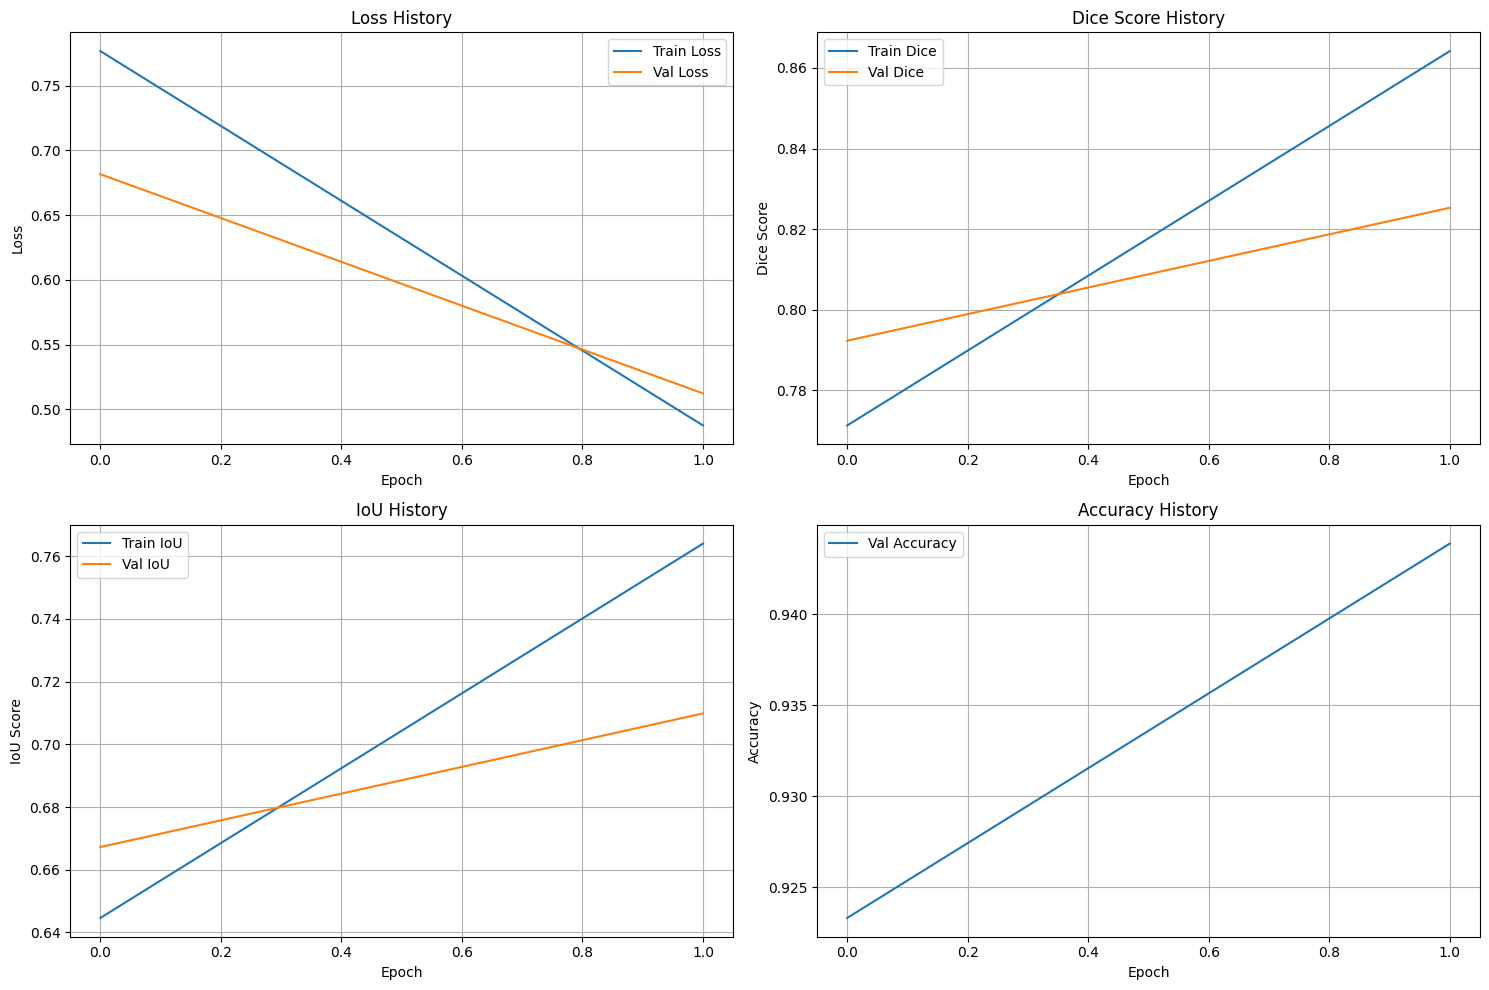


Visualizing predictions...


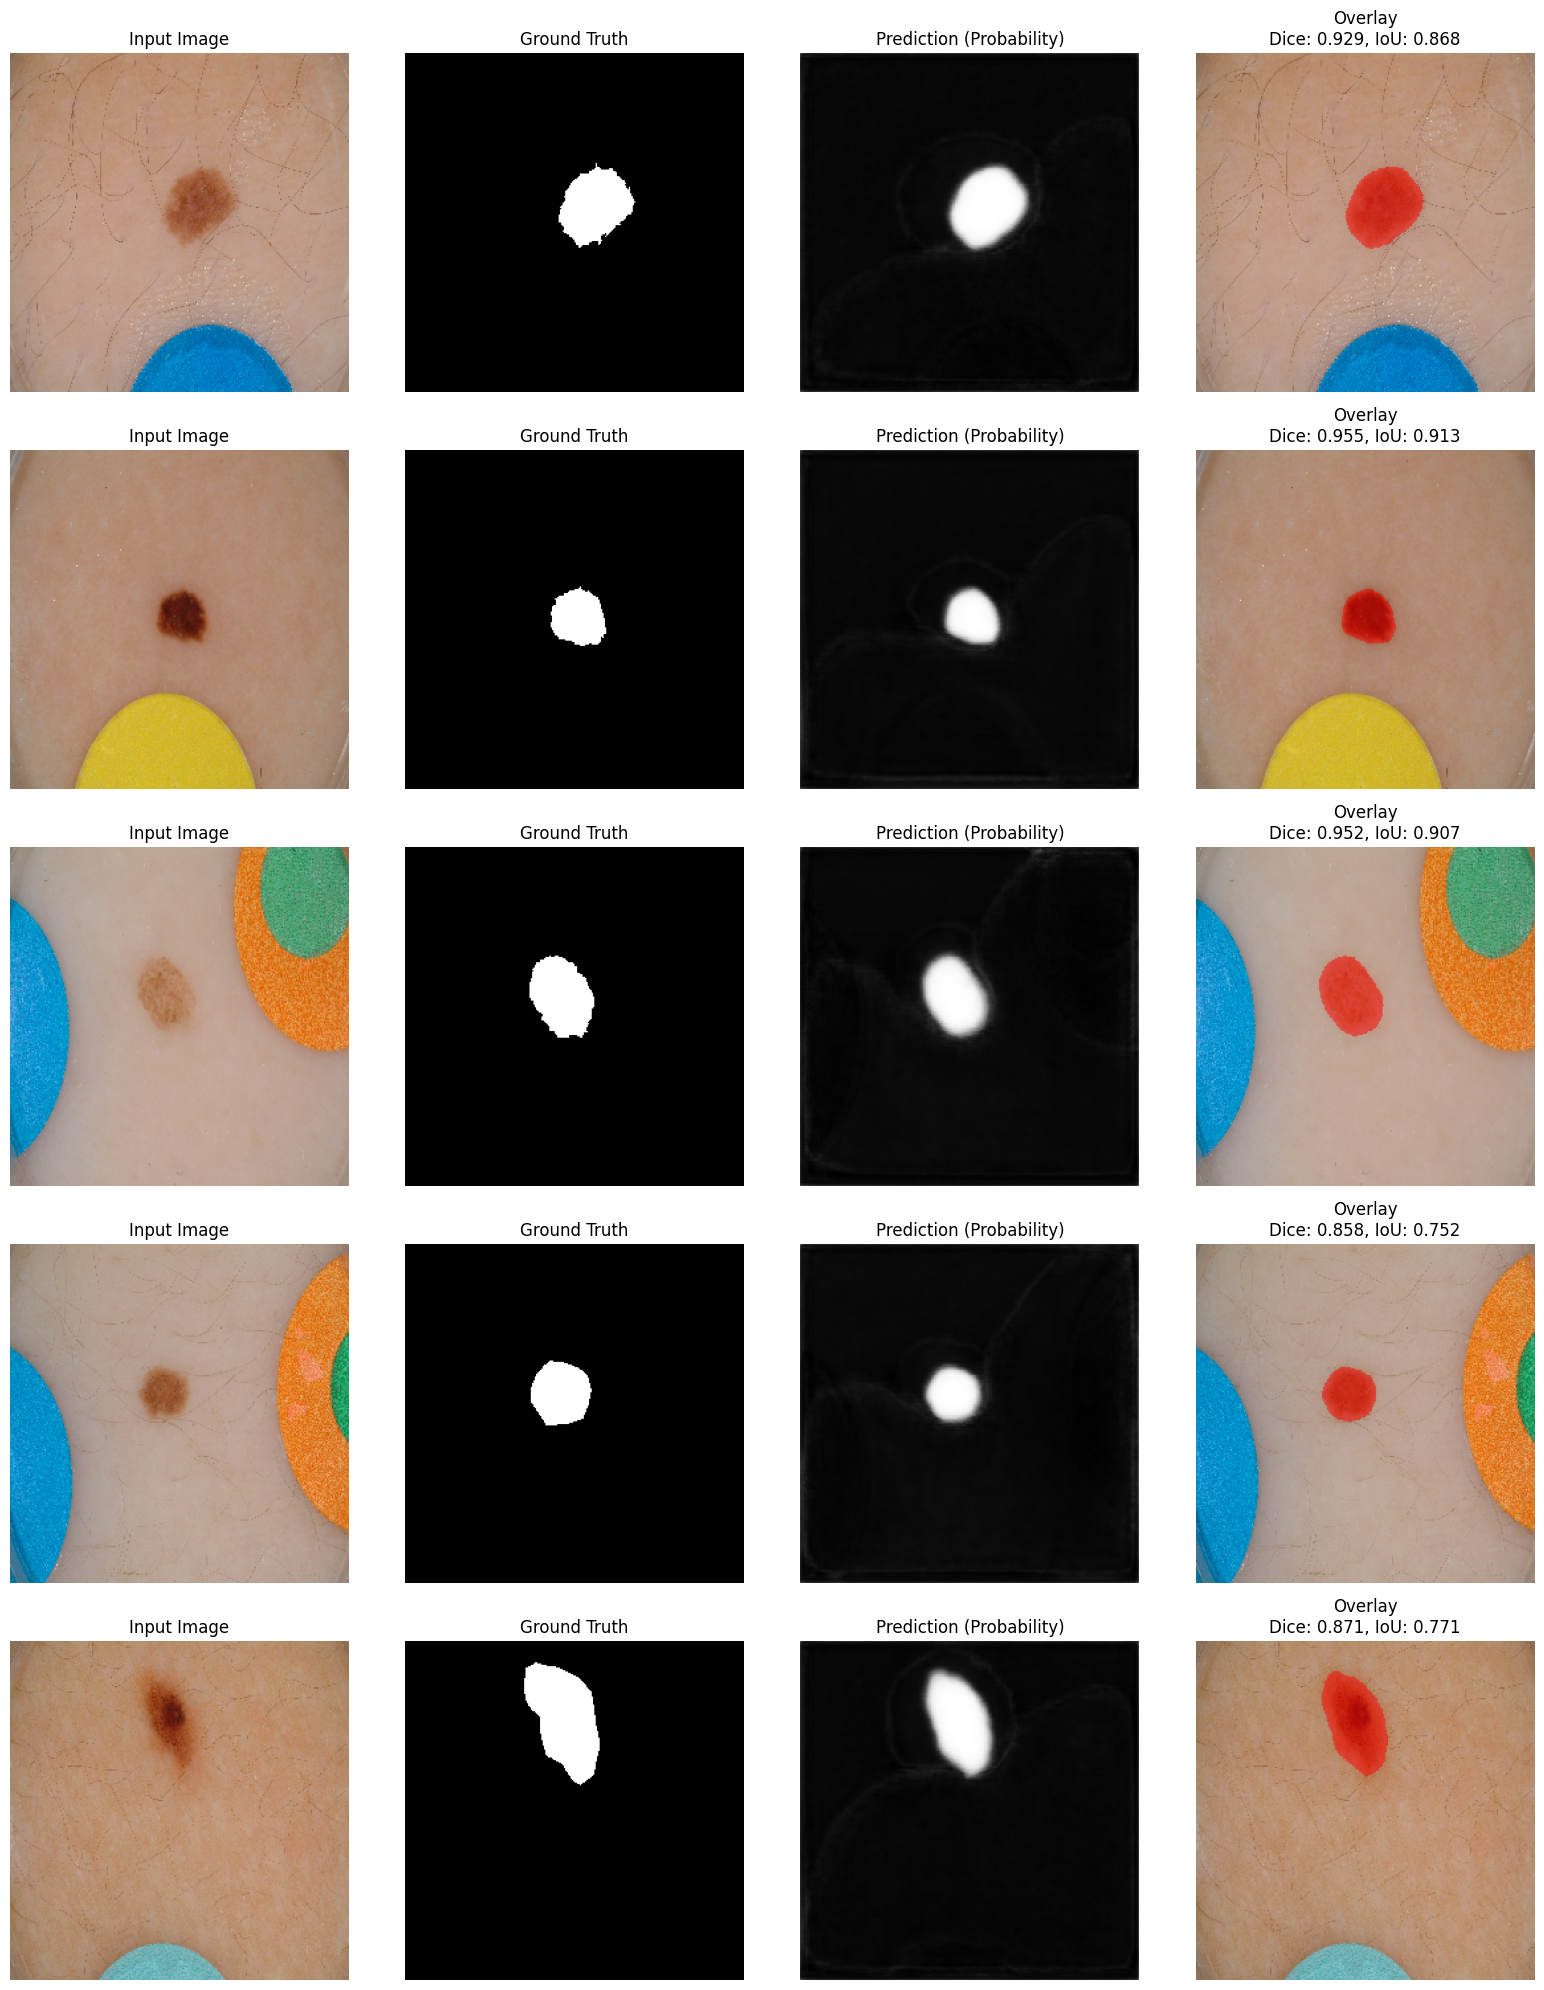


Training complete! Best validation Dice: 0.8253

FINAL TEST SET EVALUATION
Test Loss: 0.4981
Test Dice: 0.8340
Test IoU: 0.7222
Test Accuracy: 0.9349


In [5]:
def main():
    BATCH_SIZE = 16
    EPOCHS = 2
    LR = 1e-4
    IMG_SIZE = 256

    # Change to ISIC 2017 path
    DATASET_PATH = '/kaggle/input/isic-2017'

    ARCHITECTURE = "Unet"  # Much faster than DeepLabV3!
    ENCODER = "resnet34"
    ENCODER_WEIGHTS = "imagenet"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create ISIC 2017 datasets (with official splits!)
    print("Loading ISIC 2017 dataset...")
    train_dataset = ISIC2017Dataset(
        root_dir=DATASET_PATH,
        split='train',
        transform=get_train_transform(IMG_SIZE)
    )
    val_dataset = ISIC2017Dataset(
        root_dir=DATASET_PATH,
        split='val',
        transform=get_val_transform(IMG_SIZE)
    )
    test_dataset = ISIC2017Dataset(
        root_dir=DATASET_PATH,
        split='test',
        transform=get_val_transform(IMG_SIZE)
    )

    # Create loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )

    # CREATE MODEL (THIS WAS MISSING!)
    print(f"Creating {ARCHITECTURE} model with {ENCODER} encoder...")
    model = smp.create_model(
        arch=ARCHITECTURE,
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=1,  # Binary segmentation
    ).to(device)

    # Loss function
    dice_loss = smp.losses.DiceLoss(mode='binary')
    bce_loss = nn.BCEWithLogitsLoss()

    def combined_loss(pred, target):
        return dice_loss(pred, target) + bce_loss(pred, target)

    criterion = combined_loss

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    # Pre-load validation and test data to GPU
    val_imgs_gpu, val_masks_gpu = preload_val_to_gpu(val_loader, device)
    test_imgs_gpu, test_masks_gpu = preload_val_to_gpu(test_loader, device)

    # Training setup
    train_losses, val_losses = [], []
    train_dices, train_ious = [], []
    val_dices, val_ious, val_accs = [], [], []
    best_dice = 0

    scaler = GradScaler()

    # Training loop
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )

        # Use pre-loaded validation data (FAST!)
        val_loss, val_dice, val_iou, val_acc = validate_preloaded(
            model, val_imgs_gpu, val_masks_gpu, criterion, device, batch_size=BATCH_SIZE
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        train_ious.append(train_iou)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        val_accs.append(val_acc)

        scheduler.step(val_dice)

        print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
        print(f"Val Accuracy: {val_acc:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_isic_model.pth')
            print(f"Best model saved! Dice: {best_dice:.4f}")

    # Plot training history
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].set_title('Loss History')
    axes[0, 0].grid(True)

    # Dice Score
    axes[0, 1].plot(train_dices, label='Train Dice')
    axes[0, 1].plot(val_dices, label='Val Dice')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].set_title('Dice Score History')
    axes[0, 1].grid(True)

    # IoU Score
    axes[1, 0].plot(train_ious, label='Train IoU')
    axes[1, 0].plot(val_ious, label='Val IoU')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU Score')
    axes[1, 0].legend()
    axes[1, 0].set_title('IoU History')
    axes[1, 0].grid(True)

    # Accuracy
    axes[1, 1].plot(val_accs, label='Val Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].set_title('Accuracy History')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Visualize predictions
    print("\nVisualizing predictions...")
    visualize_predictions(model, val_loader, device, n_samples=5)

    print(f"\nTraining complete! Best validation Dice: {best_dice:.4f}")

    # After training, evaluate on test set
    print("\n" + "="*50)
    print("FINAL TEST SET EVALUATION")
    print("="*50)

    model.load_state_dict(torch.load('best_isic_model.pth'))
    test_loss, test_dice, test_iou, test_acc = validate_preloaded(
        model, test_imgs_gpu, test_masks_gpu, criterion, device, batch_size=BATCH_SIZE
    )

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Dice: {test_dice:.4f}")
    print(f"Test IoU: {test_iou:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

if __name__ == "__main__":
    main()